# Interactively run workflow optogenetics

- This notebook walks you through the steps in detail to run the `workflow-optogenetics`.

- If you haven't configured the paths, refer to [01-configure](01-configure.ipynb).

- To overview the schema structures, refer to [02-workflow-structure](02-workflow-structure.ipynb).

- For a more thorough introduction of DataJoint functionality, please visit our [Elements user guide](https://datajoint.com/docs/elements/user-guide/) and [general documentation](https://datajoint.com/docs/core/concepts/mantra/).


Let's change the directory to the package root directory to load the local configuration (`dj_local_conf.json`).


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

## `pipeline.py`

This script `activates` the DataJoint Elements and declares other required tables.


In [2]:
import datajoint as dj
from workflow_optogenetics.pipeline import lab, subject, surgery, session, opto, Device

[2022-12-08 15:27:54,191][INFO]: Connecting cbroz@dss-db.datajoint.io:3306
[2022-12-08 15:27:54,471][INFO]: Connected cbroz@dss-db.datajoint.io:3306


## Schema diagrams

See also [diagram notation docs](https://datajoint.com/docs/core/concepts/getting-started/diagrams/).


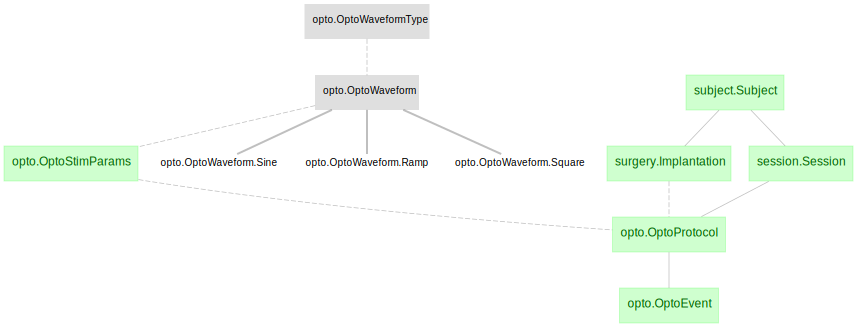

In [3]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(surgery.Implantation)
    + dj.Diagram(opto)
)

## Inserting data


### `lab` schema

`pipeline.py` adds a Device table to the `lab` schema. This table, like other `Lookup` tables, has default contents, but we can always add more.


In [4]:
Device.insert1(
    dict(
        device="OPTG_8",
        modality="Optogenetics",
        description="8 channel pulse sequence device",
    )
)

In [5]:
lab.User.insert1(
    dict(user="User1")
)  # For the surgeon attribute in surgery.Implantation

### `subject` schema


In [6]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

In [7]:
subject.Subject.insert1(
    dict(
        subject="subject3",
        sex="F",
        subject_birth_date="2020-03-03",
        subject_description="Optogenetic pilot subject.",
    )
)

In order to conduct optogenetic stimulation, our subject must have an implant in the target brain region. Again, some `Lookup` tables have useful default content.


In [8]:
surgery.CoordinateReference()

reference
bregma
dura
lambda
sagittal_suture
sinus
skull_surface


In [9]:
surgery.Hemisphere()

hemisphere Brain region hemisphere
left
middle
right


In [14]:
surgery.BrainRegion.insert1(
    dict(region_acronym="dHP", region_name="Dorsal Hippocampus")
)
surgery.Implantation.insert1(
    dict(
        subject="subject3",
        implant_date="2022-04-01 12:13:14",
        implant_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        surgeon="user1",
    )
)

surgery.Implantation.Coordinate.insert1(
    dict(
        subject="subject3",
        implant_date="2022-04-01 12:13:14",
        implant_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        ap="-7.9",  # anterior-posterior distance in mm
        ap_ref="bregma",
        ml="-1.8",  # medial axis distance in mm
        ml_ref="bregma",
        dv="5",  # dorso-ventral axis distance in mm
        dv_ref="skull_surface",
        theta="11.5",  # degree rotation about ml-axis [0, 180] wrt z
        phi="0",  # degree rotation about dv-axis [0, 360] wrt x
        beta=None,  # degree rotation about shank [-180, 180] wrt anterior
    )
)

### Insert into `session` schema


In [15]:
session.Session.describe()

-> subject.Subject
session_id           : int                          
---
session_datetime     : datetime                     



'-> subject.Subject\nsession_id           : int                          \n---\nsession_datetime     : datetime                     \n'

In [16]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_id           : int                          # 
---
session_datetime     : datetime                     # 

In [17]:
session_key = dict(
    subject="subject3", session_id="1", session_datetime="2022-04-04 12:13:14"
)
session.Session.insert1(session_key)
session.Session()

subject,session_id,session_datetime
subject3,1,2022-04-04 12:13:14


### Insert into `opto` schema


First, we'll add information to describe the stimulus, including waveform shape and and application parameters.


In [18]:
opto.OptoWaveform.insert1(
    dict(
        waveform_name="square_10",
        waveform_type="square",
        waveform_description="Square waveform: 10%/90% on/off cycle",
    )
)
# Square is one part table of OptoWaveform.
# For sine and ramp waveforms, see the corresponding tables
opto.OptoWaveform.Square.insert1(
    dict(waveform_name="square_10", on_proportion=0.10, off_proportion=0.90)
)

In [19]:
opto.OptoStimParams.insert1(
    dict(
        opto_params_id=1,
        waveform_name="square_10",
        wavelength=470,
        light_intensity=10.2,
        frequency=1,
        duration=241,
    )
)

Next, we'll describe the session in which these parameters were used with `OptoProtocol`


In [21]:
opto.OptoProtocol.insert1(
    dict(
        subject="subject3",
        session_id="1",
        protocol_id="1",
        opto_params_id="1",
        implant_date="2022-04-01 12:13:14",
        implant_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        device="OPTG_4",
    )
)

We can describe the timing of these stimulations in `OptoEvent`.


In [22]:
opto.OptoEvent.insert(
    [
        dict(
            subject="subject3",
            session_id=1,
            protocol_id=1,
            stim_start_time=241,
            stim_end_time=482,
        ),
        dict(
            subject="subject3",
            session_id=1,
            protocol_id=1,
            stim_start_time=482,
            stim_end_time=723,
        ),
    ]
)

To store more experimental timing information, see documentation for [Element Event](https://datajoint.com/docs/elements/element-event/).


## Automating inserts

This workflow provides functions for ingesting this information from csv files in `ingest.py`.

- `ingest_subjects`: subject.Subject
- `ingest_sessions`: session.Session
- `ingest_events`: Element Event schemas
- `ingest_opto`: surgery and opto schemas

For more information on each, see the docstring.


In [23]:
from workflow_optogenetics.ingest import ingest_subjects

help(ingest_subjects)

Help on function ingest_subjects in module workflow_optogenetics.ingest:

ingest_subjects(subject_csv_path: str = './user_data/subjects.csv', skip_duplicates: bool = True, verbose: bool = True)
    Ingest subjects listed in the subject column of ./user_data/subjects.csv
    
    Args:
        subject_csv_path (str, optional): Relative path to subject csv.
            Defaults to "./user_data/subjects.csv".
        skip_duplicates (bool, optional): Skips duplicates, see DataJoint insert.
            Defaults to True.
        verbose (bool, optional): Provides insertion info to StdOut. Defaults to True.



By default, these functions pull from files in the `user_files` directory. We can run each of these in succession with the default parameters with `ingest_all`.


In [24]:
from workflow_optogenetics.ingest import ingest_all

ingest_all()


---- Inserting 0 entry(s) into subject ----

---- Inserting 0 entry(s) into session ----

---- Inserting 1 entry(s) into behavior_recording ----

---- Inserting 5 entry(s) into behavior_recording__file ----

---- Inserting 4 entry(s) into _block ----

---- Inserting 8 entry(s) into _block__attribute ----

---- Inserting 2 entry(s) into #trial_type ----

---- Inserting 40 entry(s) into _trial ----

---- Inserting 40 entry(s) into _trial__attribute ----

---- Inserting 40 entry(s) into _block_trial ----

---- Inserting 3 entry(s) into #event_type ----

---- Inserting 37 entry(s) into _event ----

---- Inserting 37 entry(s) into _trial_event ----

---- Inserting 0 entry(s) into #opto_waveform ----

---- Inserting 0 entry(s) into #opto_waveform__square ----

---- Inserting 0 entry(s) into opto_stim_params ----

---- Inserting 0 entry(s) into #coordinate_reference ----

---- Inserting 0 entry(s) into brain_region ----

---- Inserting 0 entry(s) into #user ----

---- Inserting 0 entry(s) in

## Events

The above `ingest_all()` also added behavioral events we can example in conjunction with optogenetic events. For convenience, these stimulation events are also reflected in the Block design of Element Event.


In [3]:
from workflow_optogenetics.pipeline import event, trial

events_by_block = (
    trial.BlockTrial * trial.TrialEvent * trial.Block.Attribute
    & "attribute_name='stimulation'"
)
events_by_block

subject,session_id,block_id block number (1-based indexing),trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start,attribute_name,attribute_value,attribute_blob
subject3,1,1,1,center,4.864,stimulation,off,=BLOB=
subject3,1,1,1,center,10.192,stimulation,off,=BLOB=
subject3,1,1,1,center,17.865,stimulation,off,=BLOB=
subject3,1,1,3,center,59.128,stimulation,off,=BLOB=
subject3,1,1,3,left,49.536,stimulation,off,=BLOB=
subject3,1,1,3,left,64.453,stimulation,off,=BLOB=
subject3,1,1,4,center,90.447,stimulation,off,=BLOB=
subject3,1,1,4,right,73.844,stimulation,off,=BLOB=
subject3,1,1,4,right,79.506,stimulation,off,=BLOB=
subject3,1,1,5,left,101.14,stimulation,off,=BLOB=


We can readily compare the count of events or event types across 'on' and 'off' stimulation conditions.

In [4]:
events_by_block & "attribute_value='on'"

subject,session_id,block_id block number (1-based indexing),trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start,attribute_name,attribute_value,attribute_blob
subject3,1,3,22,center,509.98,stimulation,on,=BLOB=
subject3,1,3,23,center,534.82,stimulation,on,=BLOB=
subject3,1,3,24,center,555.033,stimulation,on,=BLOB=
subject3,1,3,26,center,605.523,stimulation,on,=BLOB=
subject3,1,3,29,center,673.068,stimulation,on,=BLOB=


In [5]:
events_by_block & "attribute_value='off'"

subject,session_id,block_id block number (1-based indexing),trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start,attribute_name,attribute_value,attribute_blob
subject3,1,1,1,center,4.864,stimulation,off,=BLOB=
subject3,1,1,1,center,10.192,stimulation,off,=BLOB=
subject3,1,1,1,center,17.865,stimulation,off,=BLOB=
subject3,1,1,3,center,59.128,stimulation,off,=BLOB=
subject3,1,1,3,left,49.536,stimulation,off,=BLOB=
subject3,1,1,3,left,64.453,stimulation,off,=BLOB=
subject3,1,1,4,center,90.447,stimulation,off,=BLOB=
subject3,1,1,4,right,73.844,stimulation,off,=BLOB=
subject3,1,1,4,right,79.506,stimulation,off,=BLOB=
subject3,1,1,5,left,101.14,stimulation,off,=BLOB=


## Next Steps

Interested in using Element Optogenetics for your own project? Reach out to the DataJoint team via [email](mailto:support@datajoint.com) or [Slack](https://datajoint.slack.com).
